In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from skimage.measure import marching_cubes
import math
import glob
import os
import re
import matplotlib as plt
from scipy.interpolate import RegularGridInterpolator
import trimesh
from scipy.ndimage import convolve
from tqdm import tqdm 
from joblib import Parallel, delayed
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [2]:
# Function to recursively search for files within subdirectories
def search_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

# Function to parse the filename and extract the particle type, liquid crystal fraction, anchoring strength and repetition
def parse_filename(filename):
    parts = filename.split('_')
    particle_type = parts[2]
    lc_frac = parts[5]
    anch_str = str(parts[8])
    rep = parts[12]
    return  particle_type, lc_frac, anch_str, rep

def parse_filename2(filename):
    parts = filename.split('_')
    particle_type = parts[0]
    lc_frac = parts[2]
    anch_str = str(float(parts[5]))
    frame = parts[7]
    rep = parts[9]
    return  particle_type, lc_frac, anch_str,frame, rep

# Function to extract the frame number from the filename
def extract_frame_number(filename):
    match = re.search(r"_den(\d+).csv$", filename)
    if match:
        return int(match.group(1))
    else:
        return None
    
#Function to interpolate into the 3D matrix

def trilinear_interpolate_pbc(F, x, y, z):
    # Get integer indices, wrapping around with PBC
    i = int(np.floor(x)) % F.shape[0]
    j = int(np.floor(y)) % F.shape[1]
    k = int(np.floor(z)) % F.shape[2]
    
    # Get next indices, wrapping around with PBC
    i_next = (i + 1) % F.shape[0]
    j_next = (j + 1) % F.shape[1]
    k_next = (k + 1) % F.shape[2]
    
    # Compute fractional weights
    wx1 = i_next - x if x <= i_next else x - i
    wx2 = 1 - wx1
    wy1 = j_next - y if y <= j_next else y - j 
    wy2 = 1 - wy1
    wz1 = k_next - z if z <= k_next else z - k 
    wz2 = 1 - wz1

    # Perform trilinear interpolation with periodic indexing
    Finterp = (
        F[i, j, k] * wx1 * wy1 * wz1 +
        F[i_next, j, k] * wx2 * wy1 * wz1 +
        F[i, j_next, k] * wx1 * wy2 * wz1 +
        F[i_next, j_next, k] * wx2 * wy2 * wz1 +
        F[i, j, k_next] * wx1 * wy1 * wz2 +
        F[i_next, j, k_next] * wx2 * wy1 * wz2 +
        F[i, j_next, k_next] * wx1 * wy2 * wz2 +
        F[i_next, j_next, k_next] * wx2 * wy2 * wz2
    )
    
    return Finterp

# Function to account for periodic boundary conditions
def periodic_boundary(value, min_val, max_val, size):
    """Applies periodic boundary conditions efficiently using NumPy."""
    return min_val + np.mod(value - min_val, size)

#Gaussian kernel for smoothing
def gaussian_kernel(sigma, truncate=1.0):
    """
    Returns a Gaussian kernel given a sigma value. The size of the kernel will be truncated
    based on the truncate value.
    """
    lw = int(truncate * sigma + 0.5)
    x = np.linspace(-lw, lw, 2*lw+1)
    y = np.linspace(-lw, lw, 2*lw+1)
    z = np.linspace(-lw, lw, 2*lw+1)

    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    kernel = np.exp(-(x**2 + y**2 + z**2) / (2*sigma**2))
    kernel /= kernel.sum()
    return kernel



def gaussian_smoothing_grid_periodic_updated(grid_data, sigma):
    
    # Generate the Gaussian kernel
    kernel = gaussian_kernel(sigma)
    
    # Apply convolution using wrapped boundary conditions
    smoothed_grid = convolve(grid_data, kernel, mode='wrap')
    
    return smoothed_grid

#Calculates Laplacian matrix for a given mesh for implicit fairing
def compute_laplacian_matrix(verts, faces):
    """
    Computes the cotangent Laplacian matrix L for a given triangular mesh.
    """
    n = len(verts)  # Number of vertices
    L = sp.lil_matrix((n, n))  # Sparse matrix for efficiency
    M = sp.lil_matrix((n, n))  # Mass matrix for normalization

    for f in faces:
        i, j, k = f  # Triangle indices

        # Compute edge vectors
        vi, vj, vk = verts[i], verts[j], verts[k]
        e0, e1, e2 = vj - vk, vk - vi, vi - vj

        # Compute cotangent weights
        def cotangent(v1, v2):
            cross = np.cross(v1, v2)
            norm_cross = np.linalg.norm(cross)
            if norm_cross < 1e-10:
                return 0.0
            
            return np.dot(v1, v2) / norm_cross

        cot0 = cotangent(e1, -e2)
        cot1 = cotangent(e2, -e0)
        cot2 = cotangent(e0, -e1)

        # Fill Laplacian matrix
        L[i, j] += cot0
        L[i, k] += cot1
        L[j, i] += cot0
        L[j, k] += cot2
        L[k, i] += cot1
        L[k, j] += cot2

        # Diagonal elements
        L[i, i] -= (cot0 + cot1)
        L[j, j] -= (cot0 + cot2)
        L[k, k] -= (cot1 + cot2)



    return L.tocsc()

In [ ]:
# Directory where the files are located
#file_directory = "/home/gabriel/Projects/Figures/Results/Density"
file_directory = "/home/gabriel/Projects/Isotropic/Results/Density"

# Executable command to run
executable_command = "/home/gabriel/MATILDA.FT/utils/post-proc/dump-grid-densities"

skip_frames = 4
# Get a list of all files in the directory
files =  search_files(file_directory)
# Iterate over the files
for file_path in files:
    filename = os.path.basename(file_path)
    # Check if the file matches the desired name structure
    #pattern = re.compile(r"phase_separation_(nematic|smectic)_lc_frac_0.5_anch_str_(0.0|5.0|-5.0)_Nb_6_rep_(0|1|2)_Nb_6_den.bin$")
    pattern = re.compile(r"phase_separation_isotropic_lc_frac_(0.3|0.5|0.7)_Nb_6_rep_(0|1|2)_den.bin")

    if pattern.match(filename): 
        print(filename)
        # Extract the necessary parts from the filename
        #particle_type, lc_frac, anch_str, rep = parse_filename(filename)
        particle_type = re.findall(r'(nematic|smectic|isotropic)', filename)[0]
        lc_frac = re.findall(r'frac_(0\.\d+)', filename)[0]
        matches = re.findall(r'anch_str_(-?\d+\.\d+)', filename)
        anch_str = float(matches[0]) if matches else 0.0
        
        # Create the folder name
        folder_name = f"{particle_type}_lc_frac_{lc_frac}_anch_str_{anch_str}"
        folder_path = os.path.join(file_directory, folder_name)

        # Create the folder if it doesn't exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Set the working directory to the folder
        os.chdir(folder_path)
        # Run the executable command
        command = f"{executable_command} {file_path} {filename[:-4]} {skip_frames}"
        os.system(command)
        


phase_separation_isotropic_lc_frac_0.3_Nb_6_rep_2_den.bin
Dim = 3
Nx[0]: 60
ntypes: 2
Successfully read 35 frames
phase_separation_isotropic_lc_frac_0.3_Nb_6_rep_1_den.bin
Dim = 3
Nx[0]: 60
ntypes: 2


In [3]:

# Get the list of data files
#file_directory = "/home/gabriel/Projects/Figures/Results/Density"
#file_directory = "/home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Density"
#file_directory = "/home/gabriel/Projects/Isotropic/Results/Density"
file_directory = "/home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density"
files =  search_files(file_directory)
# Function for calculating curvatures
def compute_curvature(vert):
    Ox, Oy, Oz = vert

    # Compute neighbor positions with PBC (vectorized)
    x = Xmin + np.mod(Ox + b1 - Xmin, Nx * dx)
    y = Ymin + np.mod(Oy + b2 - Ymin, Ny * dy)
    z = Zmin + np.mod(Oz + b3 - Zmin, Nz * dz)

    # Interpolated values (vectorized)
    F = np.array([trilinear_interpolate_pbc(volume_fraction, x[i], y[i], z[i]) for i in range(Nneigh)])

    # Compute weights (vectorized)
    W = np.exp(-b1**2 - b2**2 - b3**2)

    # Construct matrices and solve system
    A = P.T @ np.diag(W) @ P
    C = P.T @ (W * F)
    R = np.linalg.lstsq(A, C, rcond=None)[0]

    # Compute derivatives
    Fx, Fy, Fz = R[1:4]
    Fxx, Fyy, Fzz = 2 * R[4], 2 * R[5], 2 * R[6]
    Fxy, Fxz, Fyz = R[7:10]

    # Compute Mean & Gaussian Curvature
    Num_H = (Fx**2)*(Fyy+Fzz) - 2*Fy*Fz*Fyz + (Fy**2)*(Fxx+Fzz) - 2*Fx*Fz*Fxz + (Fz**2)*(Fxx+Fyy) - 2*Fx*Fy*Fxy
    Den_H = (Fx**2 + Fy**2 + Fz**2)**1.5
    H = Num_H / (2 * Den_H)

    Num_K = (Fx**2)*(Fyy*Fzz-Fyz**2) + 2*Fz*Fy*(Fxy*Fxz-Fyz*Fxx) + (Fy**2)*(Fxx*Fzz-Fxz**2) + \
            2*Fx*Fz*(Fxy*Fyz-Fxz*Fyy) + (Fz**2)*(Fxx*Fyy-Fxy**2) + 2*Fx*Fy*(Fxz*Fyz-Fxy*Fzz)
    Den_K = (Fx**2 + Fy**2 + Fz**2)**2
    K = Num_K / Den_K

    return H, K
# Function for implicit fairing algorithm
def implicit_fairing(verts, faces, smoothing_lambda=0.05, num_iterations=10):
    """
    Applies implicit fairing (Laplacian smoothing) to a triangular mesh.
    
    Parameters:
    - verts: (N,3) NumPy array of vertex positions.
    - faces: (M,3) NumPy array of triangle indices.
    - smoothing_lambda: Controls the amount of smoothing per iteration.
    - num_iterations: Number of smoothing iterations to apply.
    
    Returns:
    - Smoothed vertex positions.
    """
    L = compute_laplacian_matrix(verts, faces)  # Compute Laplacian
    I = sp.identity(len(verts))  # Identity matrix
    epsilon = 1e-8  # Regularization to avoid singular matrices
    
    A = (I - smoothing_lambda * L) + epsilon * I  # Regularized system
    
    new_verts = verts.copy()  # Start with the original vertices

    for _ in range(num_iterations):  # Perform smoothing iterations
        for dim in range(3):  # Solve for X, Y, Z separately
            b = new_verts[:, dim]
            new_verts[:, dim] = spla.spsolve(A, b)  

    return new_verts


#Initialize a dictionary for storing curvature values
data_dict = {}
#pattern = re.compile(r"phase_separation_(smectic|nematic)_lc_frac_0.5_anch_str_(0.0|5.0|-5.0)_Nb_6_rep_0_Nb_6_den(010|022|030).csv$")
#pattern = re.compile(r"phase_separation_isotropic_lc_frac_(0.3|0.5|0.7)_Nb_6_rep_0_den(010|022|030).csv$")
pattern = re.compile(r"avg_density_steps_20_smectic_lc_frac_0.5_anch_str_5.0_frame_10_rep_0.csv")
#Testing
#pattern = re.compile(r"phase_separation_smectic_lc_frac_0.5_anch_str_0.0_Nb_6_rep_0_den005.csv$")

# Loop over the data files
for file in tqdm(files, desc="Processing Files", unit="file"):
    filename = os.path.basename(file)
    directory = os.path.dirname(file)
    #pattern = re.compile(r"phase_separation_smectic_lc_frac_0.5_anch_str_5_Nb_6_rep_0_den0(05|10).csv$")

    if pattern.match(filename):
        particle_type = re.findall(r'(nematic|smectic|isotropic)', filename)[0]
        lc_frac = re.findall(r'frac_(0\.\d+)', filename)[0]
        matches = re.findall(r'anch_str_(-?\d+\.\d+)', filename)
        anch_str = float(matches[0]) if matches else 0.0
        rep = re.findall(r'rep_(\d)', filename)[0]
        avg = re.findall(r'steps_(\d+)', filename)[0]
        frame = re.findall(r'frame_(\d+)', filename)[0]
        
        csv_data = pd.read_csv(file)
        # Extracting data from the dataframe
        X_values = csv_data['X'].values
        Y_values = csv_data[' "Y"'].values
        Z_values = csv_data[' "Z"'].values
        #Y_values = csv_data[' Y'].values
        #Z_values = csv_data[' Z'].values
        rho0_values = csv_data[' "rho0"'].values
        rho1_values = csv_data[' "rho1"'].values
        if particle_type != "isotropic":
            rho2_values = csv_data[' "rho2"'].values
        #rho0_values = csv_data['rho0'].values
        #rho1_values = csv_data['rho1'].values
        #rho2_values = csv_data['rho2'].values

        # Determine the shape of the grid
        unique_X = np.unique(X_values)
        unique_Y = np.unique(Y_values)
        unique_Z = np.unique(Z_values)

        # Setting up the 3D grid parameters 
        dx, dy, dz = unique_X[1] - unique_X[0], unique_Y[1] - unique_Y[0], unique_Z[1] - unique_Z[0]
        one_dx, one_dy, one_dz = 1./dx, 1./dy, 1./dz
        one_dxdydz = 1./(dx*dy*dz)
        Xmin, Ymin, Zmin = unique_X[0], unique_Y[0], unique_Z[0]
        Nx, Ny, Nz = len(unique_X), len(unique_Y), len(unique_Z)
        box = [Nx*dx, Ny*dy, Nz*dz]

        # Reshaping the density values to fit a 3D grid
        rho0_grid = rho0_values.reshape((Nx, Ny, Nz))
        rho1_grid = rho1_values.reshape((Nx, Ny, Nz))
        if particle_type == "isotropic":
            volume_fraction = rho0_grid / (rho0_grid + rho1_grid )
        else:
            rho2_grid = rho2_values.reshape((Nx, Ny, Nz))
            volume_fraction = rho0_grid / (rho0_grid + rho1_grid + rho2_grid)
        # Calculating the volume fraction for polymer
        #volume_fraction = rho0_grid / (rho0_grid + rho1_grid + rho2_grid)

        # Smoothing the grid data
        #volume_fraction = gaussian_smoothing_grid_periodic(volume_fraction, sigma=.65)
        #volume_fraction = gaussian_smoothing_grid_periodic_updated(volume_fraction, sigma=1.0)

        # Extracting the isocontour using the Marching Cubes algorithm at volume_fraction = 0.5
        verts, faces, normals, values = marching_cubes(volume_fraction, 0.5)
        
        valid_indices = (verts[:, 0] > dx) & (verts[:, 0] < (Nx - 1) * dx) & \
                            (verts[:, 1] > dy) & (verts[:, 1] < (Ny - 1) * dy) & \
                            (verts[:, 2] > dz) & (verts[:, 2] < (Nz - 1) * dz)

        filtered_verts = verts[valid_indices]
        # Create a mapping from old vertex indices to new indices in filtered_verts
        old_to_new_index = -np.ones(len(verts), dtype=int)  # Default to -1 (invalid)
        old_to_new_index[np.where(valid_indices)[0]] = np.arange(len(filtered_verts))  # Map valid indices

        # Filter faces: Only keep faces where all 3 vertices are in `filtered_verts`
        valid_faces_mask = np.all(valid_indices[faces], axis=1)
        filtered_faces = faces[valid_faces_mask]

        # Reindex faces using the mapping
        faces = np.vectorize(lambda x: old_to_new_index[x])(filtered_faces).astype(int)
        
        #Implicit Fairing algorithm
        filtered_verts = implicit_fairing(filtered_verts, faces, smoothing_lambda=0.05)
        
        # Number of points on the isocontour
        Npts = len(filtered_verts)

        # Parameters for the Diffuse Approximation method
        #Nunknw = 10
        #Nunknw = 20  # Number of unknowns (10 for 2nd order, 20 for 3rd order, 35 4th order)
        Nunknw = 35
        Nmin = -3 # Neighbors below along given axis
        Nmax = 3   # Neighbors above along given axis
        Nneigh = (Nmax - Nmin + 1)**3    # Number of neighbors in total

        # Containers for storing curvature values
        mean_curvatures = []
        gauss_curvatures = []
        # Initialize matrices
        P = np.zeros((Nneigh, Nunknw))
        A = np.zeros( (Nunknw,Nunknw) )
        B = np.zeros( (Nunknw,Nneigh) )
        C = np.zeros( (Nunknw) )
        W = np.zeros( (Nneigh) )
        F = np.zeros( (Nneigh) )
        # Neigbor distances
        neighbor_offsets = np.array([(i, j, k) for i in range(Nmin, Nmax + 1) for j in range(Nmin, Nmax + 1) for k in range(Nmin, Nmax + 1)])
        b1, b2, b3 = neighbor_offsets[:, 0], neighbor_offsets[:, 1], neighbor_offsets[:, 2]
        # Distance Matrix
        P[:, 0] = 1
        P[:, 1] = b1
        P[:, 2] = b2
        P[:, 3] = b3
        P[:, 4] = b1**2
        P[:, 5] = b2**2
        P[:, 6] = b3**2
        P[:, 7] = b1*b2
        P[:, 8] = b1*b3
        P[:, 9] = b2*b3
        if Nunknw == 20:
            P[:, 10] = b1**3
            P[:, 11] = b2**3
            P[:, 12] = b3**3
            P[:, 13] = b1**2*b2
            P[:, 14] = b1**2*b3
            P[:, 15] = b1*b2**2
            P[:, 16] = b2**2*b3
            P[:, 17] = b1*b3**2
            P[:, 18] = b2*b3**2
            P[:, 19] = b1*b2*b3
        elif Nunknw == 35:
            P[:, 0] = 1
            P[:, 1] = b1
            P[:, 2] = b2
            P[:, 3] = b3
            P[:, 4] = b1**2
            P[:, 5] = b2**2
            P[:, 6] = b3**2
            P[:, 7] = b1*b2
            P[:, 8] = b1*b3
            P[:, 9] = b2*b3
            P[:, 10] = b1**3
            P[:, 11] = b2**3
            P[:, 12] = b3**3
            P[:, 13] = b1**2*b2
            P[:, 14] = b1**2*b3
            P[:, 15] = b1*b2**2
            P[:, 16] = b2**2*b3
            P[:, 17] = b1*b3**2
            P[:, 18] = b2*b3**2
            P[:, 19] = b1*b2*b3
            P[:, 20] = b1**4
            P[:, 21] = b2**4
            P[:, 22] = b3**4
            P[:, 23] = b1**3*b2
            P[:, 24] = b1**3*b3
            P[:, 25] = b1*b2**3
            P[:, 26] = b2**3*b3
            P[:, 27] = b1*b3**3
            P[:, 28] = b2*b3**3
            P[:, 29] = b1**2*b2**2
            P[:, 30] = b1**2*b3**2
            P[:, 31] = b2**2*b3**2
            P[:, 32] = b1**2*b2*b3
            P[:, 33] = b1*b2**2*b3
            P[:, 34] = b1*b2*b3**2
        # Parallel execution over all vertices
        results = Parallel(n_jobs=-1, backend="loky")(delayed(compute_curvature)(vert) for vert in tqdm(filtered_verts, desc="Calculating Curvatures"))
        mean_curvatures, gauss_curvatures = map(np.array, zip(*results))

        data_dict[filename] = {
            "directory": directory,
            "mean_curvature": mean_curvatures, 
            "gauss_curvatures": gauss_curvatures, 
            "vertices": filtered_verts.tolist(),
            "faces": faces.tolist(),
            "particle_type": particle_type,
            "lc_frac": lc_frac,
            "anch_str": anch_str,
            "frame": frame,
            "rep": rep,
            "avg": avg
            }
        
    
    


Processing Files:   0%|          | 0/1052 [00:00<?, ?file/s]

Processing Files: 100%|██████████| 1052/1052 [02:37<00:00,  6.69file/s]


/home/gabriel/anaconda3/envs/MDAnalysis/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/gabriel/anaconda3/envs/MDAnalysis/lib/python3.12/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
2025-03-24 11:58:34.050 (  34.978s) [         3D84740]   vtkTextureObject.cxx:1025   ERR| vtkTextureObject (0x55b9c14fc160): Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 74918 was requested.
ERROR:root:Attempt to use a texture buffer exceeding your hardware's limits. This can happen when trying to color by cell data with a large dataset. Hardware limit is 65536 values while 74918 was requested.


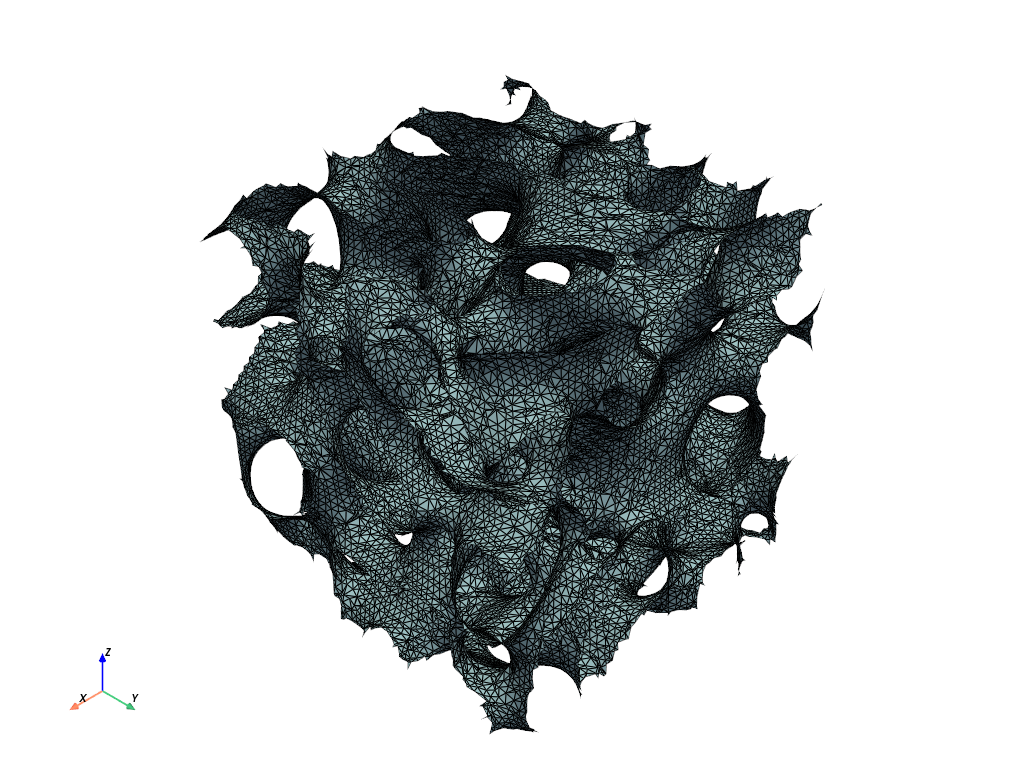

In [5]:
import pyvista as pv

# Assuming 'filtered_verts' and 'faces' are NumPy arrays or lists
for filename, data in data_dict.items():
    # Extract the data
    vertices = np.array(data["vertices"])
    faces = np.array(data["faces"])

    # PyVista expects faces in a flat array with leading count per face
    # i.e., [3, pt1, pt2, pt3, 3, pt4, pt5, pt6, ...]
    faces_flat = np.hstack([np.insert(f, 0, 3) for f in faces])

    # Create the mesh
    mesh = pv.PolyData(vertices, faces_flat)

    # Optional: Add curvature as scalars (e.g., mean curvature)
    #mesh["Mean Curvature"] = np.array(data["mean_curvature"])

    # Visualize
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, show_edges=True, color="lightblue")
    plotter.add_axes()
    plotter.show()


In [33]:
for filename, data in data_dict.items():
    print(f"Number of faces in {filename} is {len(data['faces'])}")
    print(f"Number of vertices in {filename} is {len(data['vertices'])}")
    print(f"Number of gauss curvatures in {filename} is {len(data['gauss_curvatures'])}")
    gauss_curvatures = data["gauss_curvatures"]
    smooth_verts = np.array(data["vertices"])
    faces = np.array(data["faces"])
    avg_gauss_curvatures = np.zeros(len(faces))
    gauss_curvatures_per_face = gauss_curvatures[faces]
    i = 0
    for face in faces:
        sum =0
        for vertex in face:
            sum += gauss_curvatures[vertex]
        avg_gauss_curvatures[i] = sum/len(face)
    norm_gauss_curv = (gauss_curvatures - np.min(gauss_curvatures))/(np.max(gauss_curvatures)-np.min(gauss_curvatures))
    colormap = plt.cm.coolwarm
    colors1 = colormap(norm_gauss_curv)
    color2 = colors1[faces][:,1]
    print(len(avg_gauss_curvatures))  
    print(len(colors1)) 
    print(len(color2))    

Number of faces in phase_separation_smectic_lc_frac_0.5_anch_str_0.0_Nb_6_rep_0_den022.csv is 32390
Number of vertices in phase_separation_smectic_lc_frac_0.5_anch_str_0.0_Nb_6_rep_0_den022.csv is 16720
Number of gauss curvatures in phase_separation_smectic_lc_frac_0.5_anch_str_0.0_Nb_6_rep_0_den022.csv is 16720


TypeError: only integer scalar arrays can be converted to a scalar index

In [86]:
import csv
import os
import numpy as np

def save_curvature_data_to_csv(data):
    directory = "/home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Curvatures"
    particle_type = data["particle_type"]
    lc_frac = data["lc_frac"]
    anch_str = data["anch_str"]
    faces = np.array(data["faces"])  # Ensure faces is a NumPy array for easier indexing
    frame = data["frame"]
    avg = data["avg"]
    rep = data["rep"]
    vertices = np.array(data["vertices"])
    mean_curvatures = np.array(data["mean_curvature"])
    gauss_curvatures = np.array(data["gauss_curvatures"])

    # Filename based on given format
    filename = f"{particle_type}_frac_{lc_frac}_anch_str_{anch_str}_frame_{frame}_{avg}_step_avg_rep_{rep}_curvatures.csv"
    filepath = os.path.join(directory, filename)

    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["Face_Index", "Vertex_X1", "Vertex_Y1", "Vertex_Z1", "Mean_Curvature1", "Gauss_Curvature1",
                         "Vertex_X2", "Vertex_Y2", "Vertex_Z2", "Mean_Curvature2", "Gauss_Curvature2",
                         "Vertex_X3", "Vertex_Y3", "Vertex_Z3", "Mean_Curvature3", "Gauss_Curvature3"])

        # Iterate over each face
        for face_idx, face in enumerate(faces):
            # Each face contains indices of its three vertices
            vertex_data = []
            for vertex_idx in face:
                vertex_coords = vertices[vertex_idx]
                mean_curvature = mean_curvatures[vertex_idx]
                gauss_curvature = gauss_curvatures[vertex_idx]
                # Append vertex data: coordinates and curvatures
                vertex_data.extend([vertex_coords[0], vertex_coords[1], vertex_coords[2], mean_curvature, gauss_curvature])

            # Write the face data with its vertices
            writer.writerow([face_idx] + vertex_data)

    print(f"Data saved to {filepath}")

# Using the function
for filename, data in data_dict.items():
    save_curvature_data_to_csv(data)


Data saved to /home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density/smectic_frac_0.5_anch_str_5.0_frame_10_20_step_avg_rep_0_curvatures.csv
Data saved to /home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density/smectic_frac_0.5_anch_str_-5.0_frame_31_20_step_avg_rep_0_curvatures.csv
Data saved to /home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density/smectic_frac_0.5_anch_str_0.0_frame_10_20_step_avg_rep_0_curvatures.csv
Data saved to /home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density/nematic_frac_0.5_anch_str_5.0_frame_22_20_step_avg_rep_0_curvatures.csv
Data saved to /home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density/smectic_frac_0.5_anch_str_-5.0_frame_22_20_step_avg_rep_0_curvatures.csv
Data saved to /home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Avg_Density/nematic_frac_0.5_anch_str_0.0_frame_10_20_st

In [25]:
import pandas as pd
import os
import re
import numpy as np

def read_curvature_data(directory):
    """
    Reads curvature data from CSV files and stores it in a dictionary format
    matching the simulation pipeline.

    Parameters:
    - directory (str): Path to the directory containing curvature CSV files.

    Returns:
    - dict: Dictionary where keys are filenames and values are curvature data
            (matching the format used by the simulation pipeline).
    """

    files = search_files(directory)  # Get list of all files in the directory
    data_dict = {}  # Dictionary to store structured data

    for file_path in files:
        if file_path.endswith("_curvatures.csv"):
            df = pd.read_csv(file_path)  # Read CSV file

            filename = os.path.basename(file_path)
            directory = os.path.dirname(file_path)

            unique_vertices = []
            vertex_indices = {}
            faces = []
            
            # Process each face in the dataframe
            for idx, row in df.iterrows():
                face = []
                
                # Process each vertex in the face (3 vertices per face)
                for i in range(1, 4):
                    # Extract vertex coordinates
                    vertex = (row[f'Vertex_X{i}'], row[f'Vertex_Y{i}'], row[f'Vertex_Z{i}'])
                    
                    # Check if vertex already exists, if not add it
                    vertex_tuple = tuple(vertex)
                    if vertex_tuple not in vertex_indices:
                        vertex_indices[vertex_tuple] = len(unique_vertices)
                        unique_vertices.append(list(vertex))
                    
                    # Add vertex index to the current face
                    face.append(vertex_indices[vertex_tuple])
                
                faces.append(face)
            
            # Extract curvature values for each unique vertex
            mean_curvatures = np.zeros(len(unique_vertices))
            gauss_curvatures = np.zeros(len(unique_vertices))
            
            # Map the curvature values to the corresponding vertices
            for idx, row in df.iterrows():
                for i in range(1, 4):
                    vertex = (row[f'Vertex_X{i}'], row[f'Vertex_Y{i}'], row[f'Vertex_Z{i}'])
                    vertex_idx = vertex_indices[tuple(vertex)]
                    
                    # If multiple values exist for the same vertex, we take the last one
                    # (you might want to average them instead)
                    mean_curvatures[vertex_idx] = row[f'Mean_Curvature{i}']
                    gauss_curvatures[vertex_idx] = row[f'Gauss_Curvature{i}']

            # Parse metadata from filename using regex
            particle_type = re.findall(r'(nematic|smectic|isotropic)', filename)[0]
            lc_frac = float(re.findall(r'frac_(0\.\d+)', filename)[0])
            anch_str_match = re.findall(r'anch_str_(-?\d+\.\d+)', filename)
            anch_str = float(anch_str_match[0]) if anch_str_match else 0.0
            rep = int(re.findall(r'rep_(\d)', filename)[0])
            frame = int(re.findall(r'frame_(\d+)', filename)[0])
            avg_match = re.findall(r'steps_(\d+)', filename)
            avg = int(avg_match[0]) if avg_match else None  # Some filenames may not have 'steps_xxx'

            # Store structured data in dictionary format (matching the simulation pipeline)
            data_dict[filename] = {
                "directory": directory,
                "mean_curvature": mean_curvatures,
                "gauss_curvatures": gauss_curvatures,
                "vertices": unique_vertices,
                "faces": faces,
                "particle_type": particle_type,
                "lc_frac": lc_frac,
                "anch_str": anch_str,
                "frame": frame,
                "rep": rep,
                "avg": avg
            }

    if not data_dict:
        print("❌ No valid curvature data found.")
        return {}

    return data_dict

# Define the directory containing your curvature CSV files
curvature_data_directory = "/home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Curvatures"

# Read curvature data into a structured dictionary
curvature_dict = read_curvature_data(curvature_data_directory)

# Print dictionary summary
if curvature_dict:
    sample_key = next(iter(curvature_dict))  # Get the first filename key
    print(f"Sample filename: {sample_key}")
    #print(f"Sample data: {curvature_dict[sample_key]}")
else:
    print("❌ No valid data loaded.")


Sample filename: nematic_frac_0.5_anch_str_-5.0_frame_22_20_step_avg_rep_0_curvatures.csv


In [14]:
# Logarithmic timesteps
max_steps = 2000001
n_frames  = 35
freq = 1000
steps = []
mult_factor = (max_steps/freq)**(1/(n_frames))
for i in range(n_frames):
    freq = freq*mult_factor
    steps.append(int(freq))

print(steps)


[1242, 1543, 1918, 2383, 2961, 3680, 4573, 5682, 7060, 8773, 10901, 13545, 16830, 20912, 25985, 32288, 40119, 49850, 61942, 76966, 95635, 118831, 147655, 183469, 227970, 283265, 351972, 437345, 543424, 675234, 839014, 1042520, 1295388, 1609589, 2000000]


In [9]:
# Directory containing the k_star data CSVs
k_star_dir = "/home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Q_star"

def load_k_star_data(k_star_dir):
    """
    Reads all k_star CSV files and combines them into a single DataFrame.

    Parameters:
    - k_star_dir (str): Directory containing k_star CSV files.

    Returns:
    - pd.DataFrame: DataFrame with k_star values indexed by (lc_type, lc_fraction, anchoring_strength, frame).
    """
    all_files = [f for f in os.listdir(k_star_dir) if f.endswith("_k_star.csv")]
    data_frames = []

    for file in all_files:
        file_path = os.path.join(k_star_dir, file)
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        required_columns = ["lc_type", "lc_fraction", "anchoring_strength", "timestep", "k_star_mean", "k_star_std", "frame"]
        if not all(col in df.columns for col in required_columns):
            print(f"⚠️ Skipping {file}: Missing columns.")
            continue

        data_frames.append(df)

    if data_frames:
        combined_df = pd.concat(data_frames, ignore_index=True)
        return combined_df
    else:
        print("❌ No valid k_star data found.")
        return pd.DataFrame()

# Load k_star values
k_star_df = load_k_star_data(k_star_dir)

# Convert to dictionary for fast lookup
k_star_lookup = k_star_df.set_index(["lc_type", "lc_fraction", "anchoring_strength", "frame"])["k_star_mean"].to_dict()


In [63]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def group_curvature_data(grouped_curv_data, filename, data, particle_types, lc_fracs, anch_strs, frame_values, grouping):
    """
    Groups curvature data based on different simulation properties.

    Parameters:
    - grouped_curv_data (dict): Dictionary storing grouped curvature data.
    - filename (str): Name of the file being processed.
    - data (dict): Dictionary containing curvature data.
    - particle_types, lc_fracs, anch_strs, frame_values (list): Lists of property values.
    - grouping (str): The grouping type ("particle", "fraction", "anchoring", "frame").

    Returns:
    - grouped_curv_data (dict): Updated dictionary with grouped data.
    """
    directory = data["directory"]
    particle_type = data["particle_type"]
    lc_frac = data["lc_frac"]
    anch_str = float(data["anch_str"])
    frame = data["frame"]

    # Define grouping keys and data structure
    grouping_keys = {
        "particle_type": (lc_frac, anch_str, frame, particle_types, "particle"),
        "lc_frac": (particle_type, anch_str, frame, lc_fracs, "frac"),
        "anch_str": (particle_type, lc_frac, frame, anch_strs, "anch"),
        "frame": (particle_type, lc_frac, anch_str, frame_values, "frame"),
    }

    if grouping not in grouping_keys:
        raise ValueError(f"Invalid grouping: {grouping}")

    key, value_list, prefix = grouping_keys[grouping][:3], grouping_keys[grouping][3], grouping_keys[grouping][4]

    # Initialize group if not exists
    if key not in grouped_curv_data:
        grouped_curv_data[key] = {f"{grouping}_{val}_gauss": [] for val in value_list}
        grouped_curv_data[key].update({f"{grouping}_{val}_mean": [] for val in value_list})
        grouped_curv_data[key].update({"directory": directory, "filename": filename})

    # Append curvature data
    curv_key_gauss = f"{grouping}_{data[grouping]}_gauss"
    curv_key_mean = f"{grouping}_{data[grouping]}_mean"
    grouped_curv_data[key][curv_key_gauss].extend(data["gauss_curvatures"])
    grouped_curv_data[key][curv_key_mean].extend(data["mean_curvature"])

    return grouped_curv_data

def visualize_curvature(smooth_verts, faces, gauss_curvatures, mean_curvatures, particle_type, lc_frac, anch_str, frame_step, directory, filename):
    """
    Visualizes curvature on a Poly3D mesh using the average Gaussian and mean curvature values.

    Parameters:
    - smooth_verts (np.array): Smoothed vertex positions.
    - faces (np.array): Triangle face indices.
    - gauss_curvatures (np.array): Gaussian curvature values per vertex.
    - mean_curvatures (np.array): Mean curvature values per vertex.
    - particle_type (str): Type of particle in the simulation.
    - lc_frac (float): Liquid crystal fraction.
    - anch_str (float): Anchoring strength.
    - frame_step (int): Frame step.
    - directory (str): Output directory for saving images.
    - filename (str): Output filename.
    """
    faces = faces.astype(int)  # Ensure faces are integer indices
    print("Type of gauss_curvatures:", type(gauss_curvatures))
    print("Type of mean_curvatures:", type(mean_curvatures))

    # **Step 1: Compute Average Curvature for Each Face**
    avg_gauss_curvatures = np.mean(gauss_curvatures[faces], axis=1)
    avg_mean_curvatures = np.mean(mean_curvatures[faces], axis=1)

    # **Step 2: Normalize Curvature Values for Color Mapping**
    norm_gauss = Normalize(vmin=-0.2, vmax=0.2)
    norm_mean = Normalize(vmin=-0.4, vmax=0.4)
    
    colormap = plt.cm.coolwarm  # Choose colormap
    colors_gauss = colormap(norm_gauss(avg_gauss_curvatures))
    colors_mean = colormap(norm_mean(avg_mean_curvatures))

    # **Step 3: Create Figure and Axes**
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # **Step 4: Create Poly3DCollection for Mesh with Colors**
    gauss_mesh = Poly3DCollection(smooth_verts[faces], facecolors=colors_gauss, alpha=0.5)
    mean_mesh = Poly3DCollection(smooth_verts[faces], facecolors=colors_mean, alpha=0.5)

    ax1.add_collection3d(gauss_mesh)
    ax2.add_collection3d(mean_mesh)

    # **Step 5: Set Axes Limits and Labels**
    for ax in [ax1, ax2]:
        ax.set_xlim(0, 60)
        ax.set_ylim(0, 60)
        ax.set_zlim(0, 60)
        ax.set_xlabel("X", fontsize=16)
        ax.set_ylabel("Y", fontsize=16)
        ax.set_zlabel("Z", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)

    # **Step 6: Set Titles**
    title = rf"Particle: {particle_type}, $\phi_{{LC}}$={lc_frac}, $\Delta \chi$={int(float(anch_str))}, Step = {frame_step}"
    ax1.set_title(f"Gaussian Curvature\n{title}", fontsize=18)
    ax2.set_title(f"Mean Curvature\n{title}", fontsize=18)

    # **Step 7: Add Colorbars**
    cbar_ax1 = fig.add_axes([0.5, 0.15, 0.02, 0.7])  # Position colorbars
    cbar_ax2 = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    
    cbar1 = plt.colorbar(ScalarMappable(norm=norm_gauss, cmap=colormap), cax=cbar_ax1)
    cbar1.set_label("Gauss Curvature", rotation=270, labelpad=15, fontsize=16)

    cbar2 = plt.colorbar(ScalarMappable(norm=norm_mean, cmap=colormap), cax=cbar_ax2)
    cbar2.set_label("Mean Curvature", rotation=270, labelpad=15, fontsize=16)

    # **Step 8: Save and Show the Plot**
    curvature_output_path = os.path.join(directory, f"{filename[:-10]}_curvature_visualization.png")
    plt.savefig(curvature_output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

def plot_histograms(curv_data, key, value_list, steps, frame_step, grouping):
    """
    Plots histograms of Gaussian and Mean curvature based on a given grouping.

    Parameters:
    - curv_data (dict): Dictionary containing grouped curvature data.
    - key (tuple): Grouping key.
    - value_list (list): List of values for the grouping variable.
    - grouping (str): The grouping type ("particle", "fraction", "anchoring", "frame").
    - steps (dict): Step mapping for the frames.
    - frame_step (int): Step average.

    Saves:
    - Histogram as a PNG file.
    """
    directory = curv_data["directory"]
    filename = curv_data["filename"]

    fig, axs = plt.subplots(1, 2, figsize=(12, 10))
    colors = ["red", "blue", "green", "purple", "orange"]

    labels = {
        "particle_type": lambda v: f"{v}",
        "lc_frac": lambda v: rf"$\phi_{{LC}}={v}$",
        "anch_str": lambda v: rf"$\Delta \chi = {v}$",
        "frame": lambda v: f"Step = {steps[int(v)]}"
    }

    title_keys = {
        "particle_type": (rf"$\phi_{{LC}}$={key[0]}", rf"$\Delta \chi$={int(float(key[1]))}", f"step = {steps[int(key[2])]}"),
        "lc_frac": (f"Particle type = {key[0]}", rf"$\Delta \chi$={int(float(key[1]))}", f"step = {steps[int(key[2])]}"),
        "anch_str": (f"Particle type = {key[0]}", rf"$\phi_{{LC}}$={key[1]}", f"Step_avg = {int(frame_step)}"),
        "frame": (f"Particle type = {key[0]}", rf"$\phi_{{LC}}$={key[1]}", rf"$\Delta \chi$={int(float(int(key[2])))}")
    }

    # Iterate through values in the selected grouping
    for index, val in enumerate(value_list):
        label = labels[grouping](val)
        color = colors[index % len(colors)]  # Cycle colors if more than available

        # Gauss Curvature
        values, bin_edges = np.histogram(curv_data[f"{grouping}_{val}_gauss"], bins=100, range=(-0.3, 0.3), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[0].semilogy(bin_centers, values, label=label, color=color, linestyle="-", marker="o")

        # Mean Curvature
        values, bin_edges = np.histogram(curv_data[f"{grouping}_{val}_mean"], bins=125, range=(-0.5, 0.5), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[1].semilogy(bin_centers, values, label=label, color=color, linestyle="-", marker="o")

    # Titles and labels
    title_params = title_keys[grouping]
    axs[0].set_title(f"Gauss Curvature:\n{title_params[0]}, {title_params[1]}, {title_params[2]}")
    axs[1].set_title(f"Mean Curvature:\n{title_params[0]}, {title_params[1]}, {title_params[2]}")
    axs[0].set_xlabel("Gauss Curvature")
    axs[1].set_xlabel("Mean Curvature")
    axs[0].set_yscale("log")
    axs[1].set_yscale("log")

    axs[0].legend()
    axs[1].legend()
    axs[0].tick_params(axis='both', which='major', labelsize=18)
    axs[1].tick_params(axis='both', which='major', labelsize=18)
    
    axs[0].set_ylim(bottom=1e-2)
    axs[1].set_ylim(bottom=1e-2)
    plt.show()
    # Save and show the plot
    hist_output_path = os.path.join(directory, f"{filename[:-14]}_{grouping}_histogram_comparison.png")
    plt.savefig(hist_output_path, format='png')
    plt.close()
    
def plot_curvature_scatter(curv_data, key, value_list, steps, frame_step, grouping, comparison_type="anch_str", log_scale=False):
    """
    Plots Gaussian curvature vs. Mean curvature with an option to compare 
    different particle types, anchoring strengths, or frames.

    Parameters:
    - curv_data (dict): Dictionary containing grouped curvature data.
    - key (tuple): Grouping key.
    - value_list (list): List of values for the comparison variable.
    - grouping (str): The primary grouping type ("particle", "fraction", "anchoring", "frame").
    - comparison_type (str): The category to compare ("particle_type", "anch_str", "frame").
    - steps (dict): Step mapping for the frames.
    - frame_step (int): Step average.
    - log_scale (bool): Whether to use a logarithmic scale.

    Saves:
    - Scatter plot as a PNG file.
    """
    directory = curv_data["directory"]
    filename = curv_data["filename"]

    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "brown", "pink", "gray"]

    labels = {
        "particle_type": lambda v: f"Particle: {v}",
        "lc_frac": lambda v: rf"$\phi_{{LC}}={v}$",
        "anch_str": lambda v: rf"$\Delta \chi = {v}$",
        "frame": lambda v: f"Step = {steps[int(v)]}"
    }

    title_keys = {
        "particle_type": (rf"$\phi_{{LC}}$={key[0]}", rf"$\Delta \chi$={int(float(key[1]))}", f"Step = {steps[int(key[2])]}"),
        "lc_frac": (f"Particle = {key[0]}", rf"$\Delta \chi$={int(float(key[1]))}", f"Step = {steps[int(key[2])]}"),
        "anch_str": (f"Particle = {key[0]}", rf"$\phi_{{LC}}$={key[1]}", f"Step = {steps[int(key[2])]}"),
        "frame": (f"Particle = {key[0]}", rf"$\phi_{{LC}}$={key[1]}", rf"$\Delta \chi$={int(float(key[2]))}")
    }

    # Iterate through values in the selected comparison grouping
    for index, val in enumerate(value_list):
        gauss_key = f"{comparison_type}_{val}_gauss"
        mean_key = f"{comparison_type}_{val}_mean"

        if gauss_key in curv_data and mean_key in curv_data:
            gauss_curvature = np.array(curv_data[gauss_key])
            mean_curvature = np.array(curv_data[mean_key])

            label = labels[comparison_type](val)
            color = colors[index % len(colors)]  # Cycle through colors

            ax.scatter(mean_curvature, gauss_curvature, alpha=0.6, label=label, color=color, s=10)

    # Titles and labels
    title_params = title_keys[grouping]
    ax.set_title(f"Gaussian vs. Mean Curvature:\n{title_params[0]}, {title_params[1]}, {title_params[2]}", fontsize=14)
    ax.set_xlabel("Mean Curvature", fontsize=12)
    ax.set_ylabel("Gaussian Curvature", fontsize=12)

    # Set log scale if enabled
    if log_scale:
        ax.set_xscale("log")
        ax.set_yscale("log")

    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Save and show the plot
    scatter_output_path = os.path.join(directory, f"{filename[:-14]}_{grouping}_scatter_comparison.png")
    plt.savefig(scatter_output_path, format='png', dpi=300)
    plt.show()
    plt.close()
    
def plot_2d_histogram(curv_data, key, value_list, steps, frame_step, grouping="frame", comparison_type="frame"):
    """
    Plots a 2D histogram (heatmap) showing the frequency of Gaussian curvatures at each mean curvature.

    Parameters:
    - curv_data (dict): Dictionary containing grouped curvature data.
    - key (tuple): Grouping key.
    - value_list (list): List of values for the grouping variable.
    - grouping (str): The grouping type ("particle", "fraction", "anchoring", "frame").
    - comparison_type (str): The variable to compare across plots.
    - steps (dict): Step mapping for the frames.
    - frame_step (int): Step average.

    Saves:
    - 2D histogram as a PNG file.
    """
    directory = curv_data["directory"]
    filename = curv_data["filename"]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colormap = plt.cm.viridis  # Choose a color map

    # Iterate through values in the selected grouping
    for index, val in enumerate(value_list):
        gauss_key = f"{grouping}_{val}_gauss"
        mean_key = f"{grouping}_{val}_mean"

        if gauss_key in curv_data and mean_key in curv_data:
            gauss_curvatures = np.array(curv_data[gauss_key])
            mean_curvatures = np.array(curv_data[mean_key])

            # 2D histogram (heatmap) bins
            bins_x = np.linspace(-0.5, 0.5, 100)  # Mean curvature bins
            bins_y = np.linspace(-0.3, 0.3, 100)  # Gauss curvature bins

            # Compute 2D histogram
            hist, x_edges, y_edges = np.histogram2d(mean_curvatures, gauss_curvatures, bins=[bins_x, bins_y])

            # Plot 2D histogram as heatmap
            img = ax.pcolormesh(x_edges, y_edges, hist.T, cmap=colormap)

            # Set title and labels
            label = f"{comparison_type} = {val}"
            ax.set_title(f"Gaussian vs. Mean Curvature\n {label}", fontsize=16)
            ax.set_xlabel("Mean Curvature", fontsize=14)
            ax.set_ylabel("Gaussian Curvature", fontsize=14)

            # Add color bar
            cbar = plt.colorbar(img, ax=ax)
            cbar.set_label("Frequency (log scale)", fontsize=12)

    # Save and show the plot
    hist_output_path = os.path.join(directory, f"{filename[:-14]}_{grouping}_2D_histogram.png")
    plt.savefig(hist_output_path, format="png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

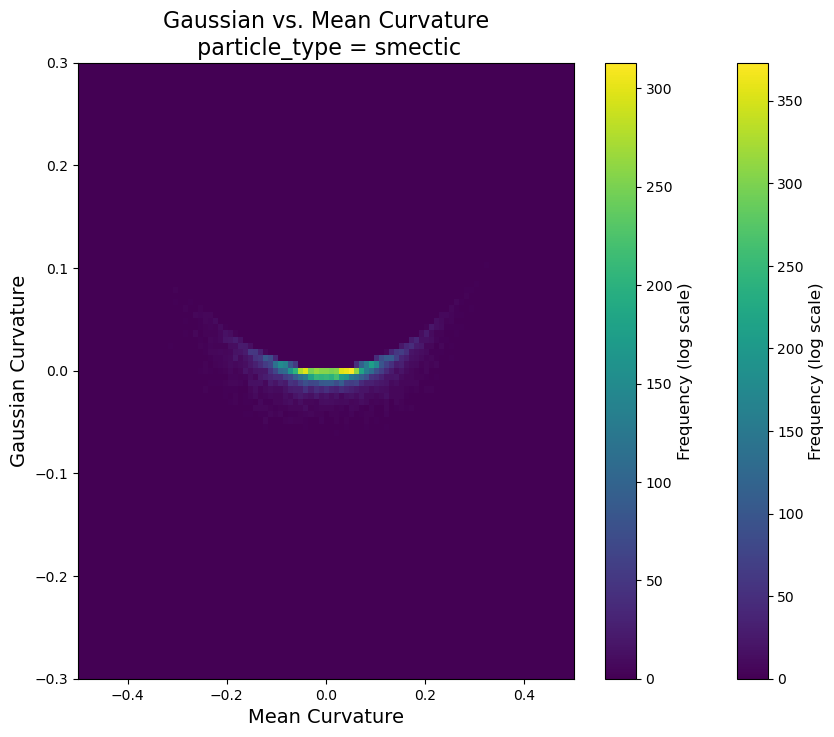

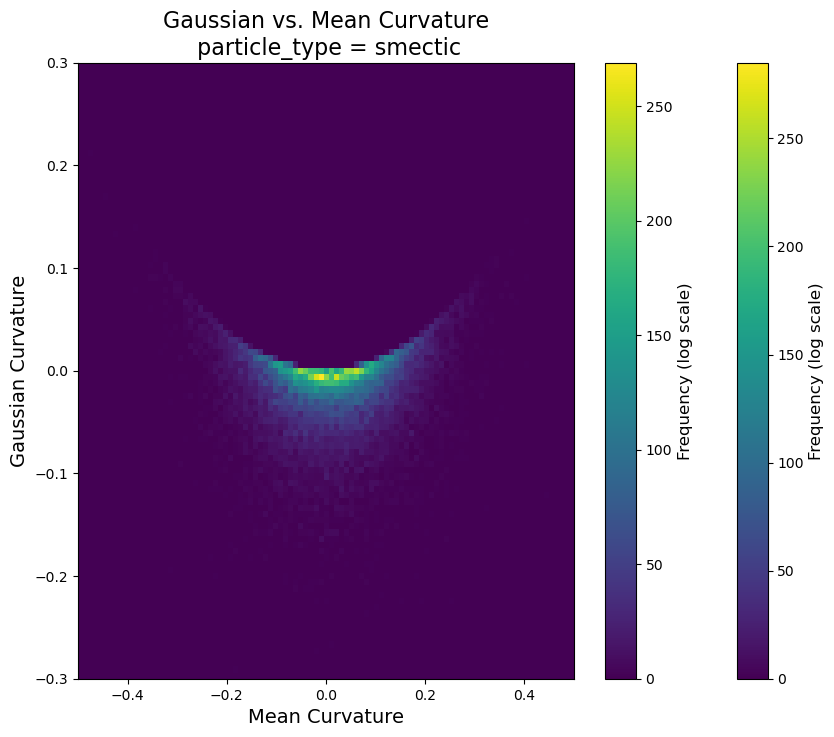

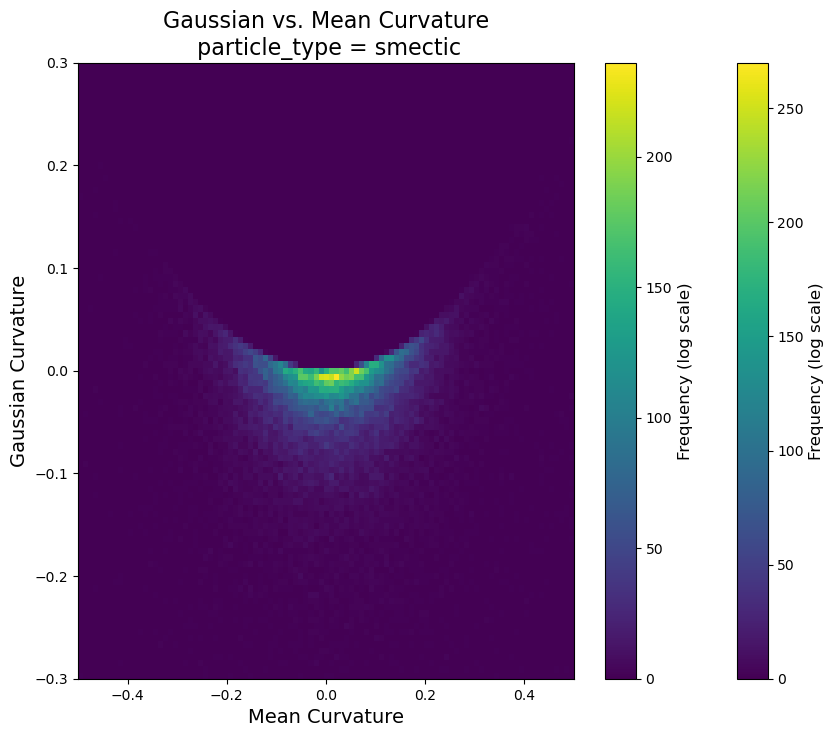

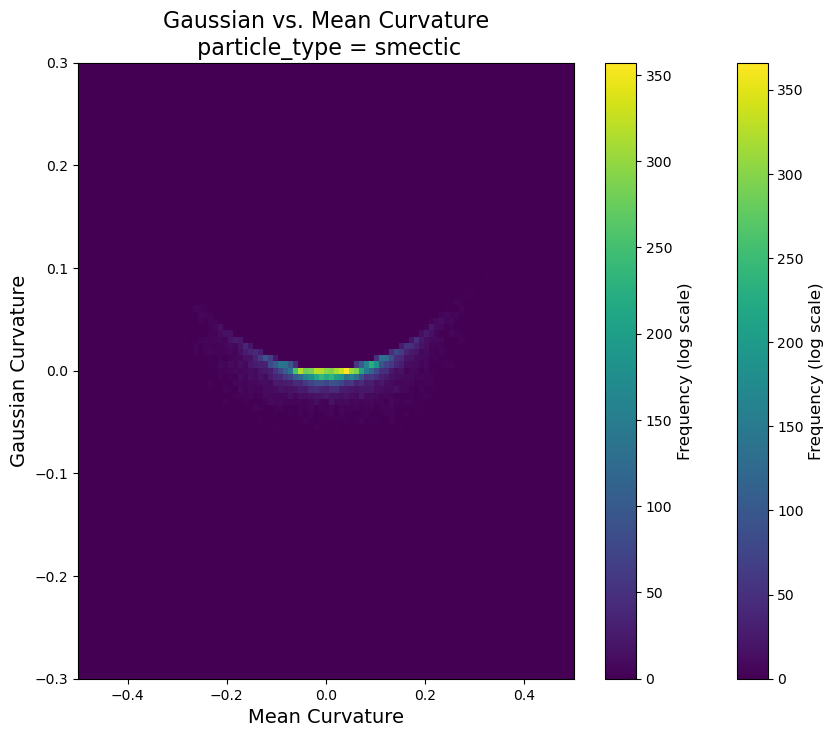

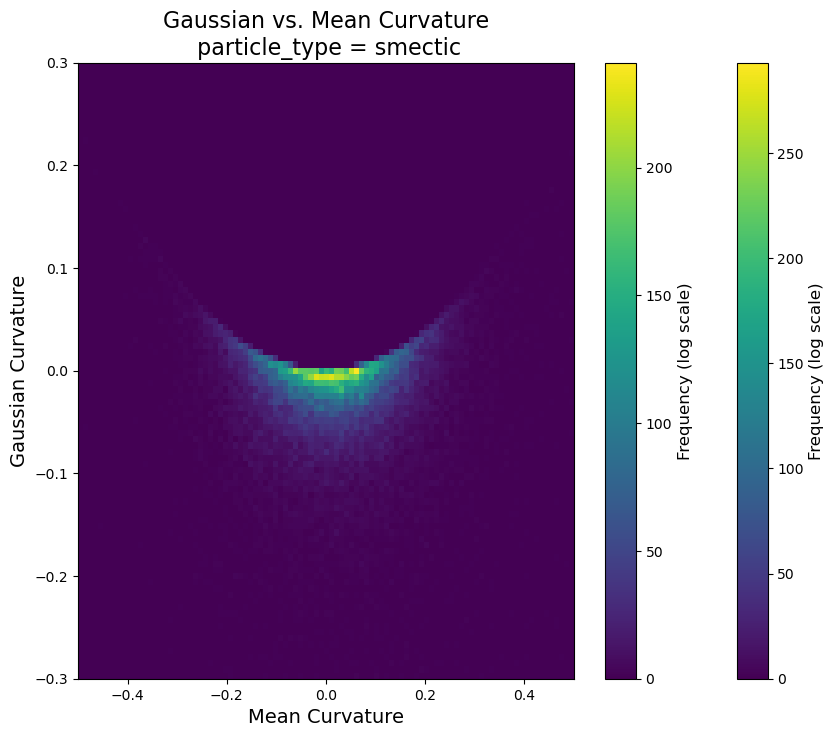

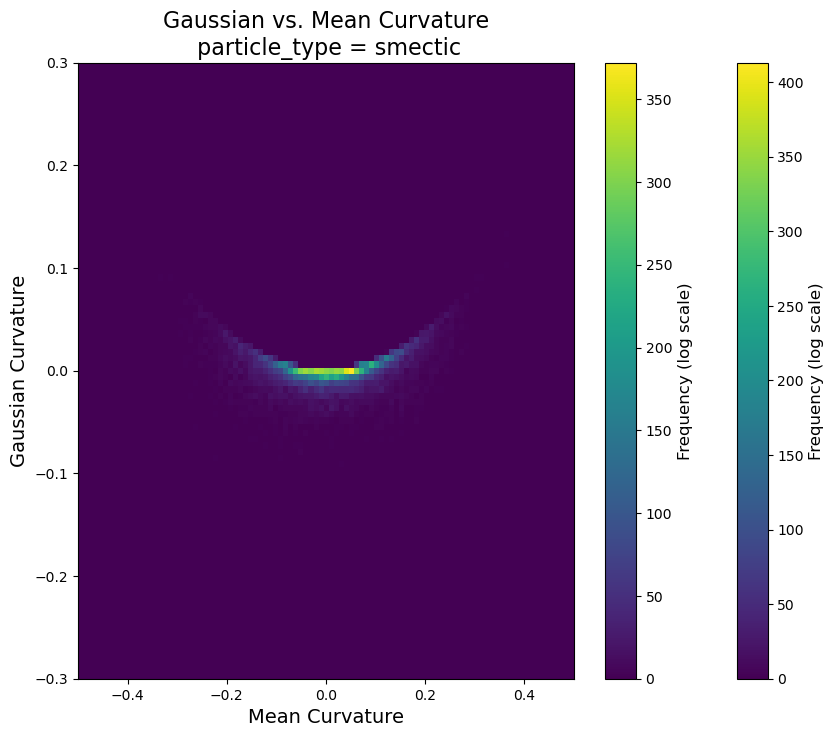

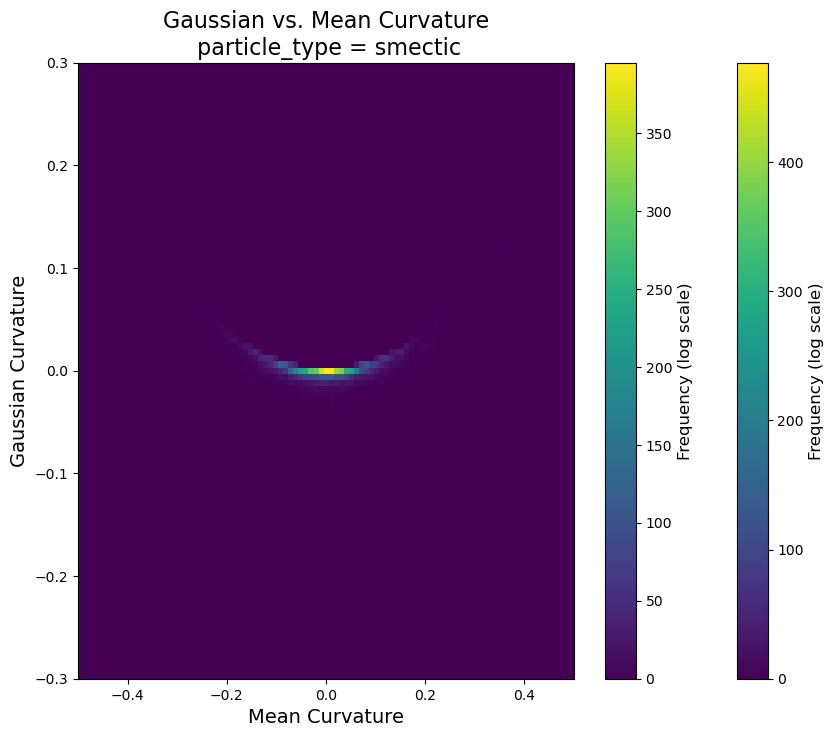

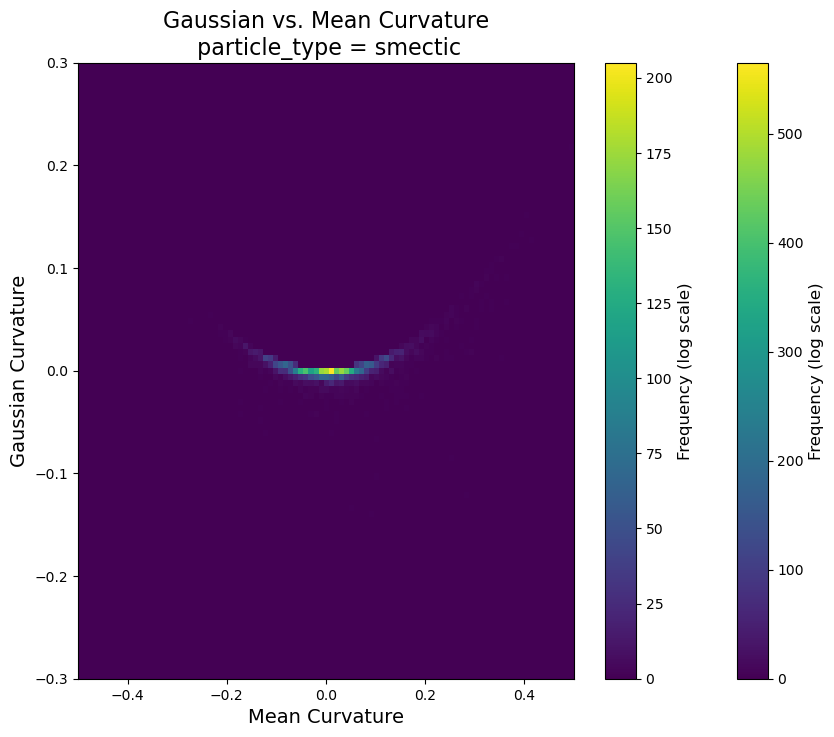

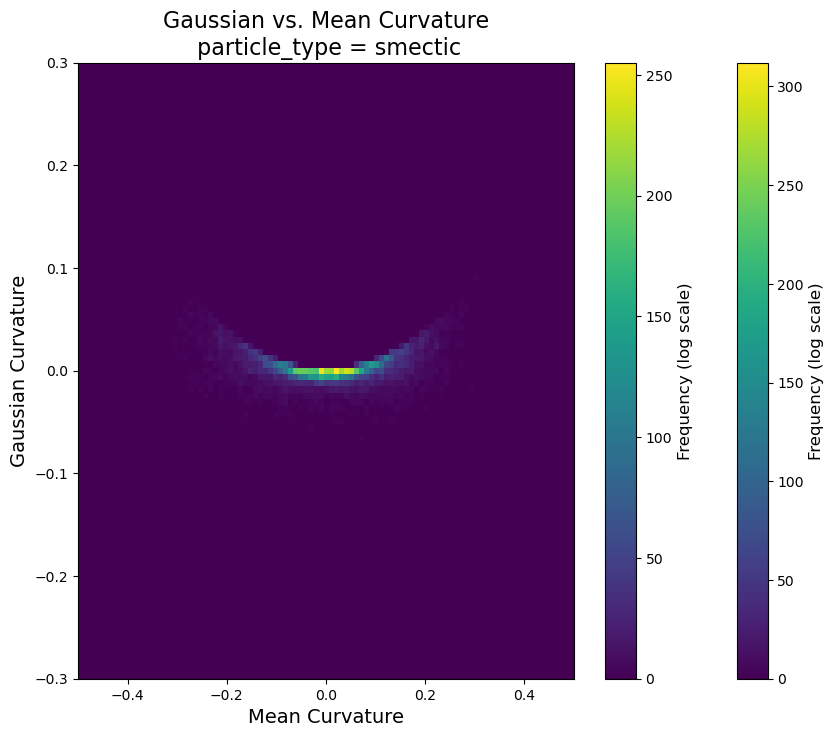

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

grouped_curv_data = {}

particle_types = sorted(list(set([inner_data["particle_type"] for inner_data in curvature_dict.values()])))
lc_fracs = sorted(list(set([inner_data["lc_frac"] for inner_data in curvature_dict.values()])))
anch_strs = sorted(list(set([inner_data["anch_str"] for inner_data in curvature_dict.values()])))
frame_values = sorted(list(set([inner_data["frame"] for inner_data in curvature_dict.values()])))
reps = sorted(list(set([inner_data["rep"] for inner_data in curvature_dict.values()])))

parameter_values = {"particle_type": particle_types, "lc_frac": lc_fracs, "anch_str": anch_strs, "frame": frame_values, "rep": reps}

group = "particle_type"
for filename, data in curvature_dict.items():
        directory = data["directory"]
        gauss_curvatures = data["gauss_curvatures"]
        mean_curvatures = data["mean_curvature"]
        smooth_verts = np.array(data["vertices"])
        faces = np.array(data["faces"])
        rep = int(data["rep"])
        particle_type = data["particle_type"]
        lc_frac = data["lc_frac"]
        anch_str = data["anch_str"]
        frame = int(data["frame"])
        frame_step = data["avg"]
        data["filename"] = filename
        grouped_curv_data = group_curvature_data(grouped_curv_data, filename, data, particle_types, lc_fracs, anch_strs, frame_values, grouping=group)
        #if rep == 0 and frame != 31:
                #visualize_curvature(smooth_verts, faces.astype(int), gauss_curvatures, mean_curvatures, particle_type, lc_frac, anch_str, frame_step if frame_step is not None else 0, directory, filename)
# Now iterate over `grouped_curv_data` to plot
#for key, curv_data in grouped_curv_data.items():
    # plot_curvature_scatter(
    #     curv_data,  # This now correctly passes the grouped curvature data
    #     key,
    #     parameter_values[group], 
    #     steps, 
    #     frame_step, 
    #     grouping=group, 
    #     comparison_type=group, 
    #     log_scale=False
    # )
for key, curv_data in grouped_curv_data.items():
    plot_2d_histogram(
        curv_data, 
        key, 
        parameter_values[group],  # Change this for different comparisons
        steps, 
        frame_step, 
        grouping=group, 
        comparison_type=group
    )

    #for key, curv_data in grouped_curv_data.items():
        #plot_histograms(curv_data, key, parameter_values[group], steps, frame_step, grouping = group)

In [ ]:
import pandas as pd
import os
import re
import numpy as np

def read_curvature_data(directory):
    """
    Reads curvature data from CSV files and stores it in a dictionary format
    matching the simulation pipeline.

    Parameters:
    - directory (str): Path to the directory containing curvature CSV files.

    Returns:
    - dict: Dictionary where keys are filenames and values are curvature data
            (matching the format used by the simulation pipeline).
    """

    files = search_files(directory)  # Get list of all files in the directory
    data_dict = {}  # Dictionary to store structured data

    for file_path in files:
        if file_path.endswith("_curvatures.csv"):
            df = pd.read_csv(file_path)  # Read CSV file

            filename = os.path.basename(file_path)
            directory = os.path.dirname(file_path)

            unique_vertices = []
            vertex_indices = {}
            faces = []
            
            # Process each face in the dataframe
            for idx, row in df.iterrows():
                face = []
                
                # Process each vertex in the face (3 vertices per face)
                for i in range(1, 4):
                    # Extract vertex coordinates
                    vertex = (row[f'Vertex_X{i}'], row[f'Vertex_Y{i}'], row[f'Vertex_Z{i}'])
                    
                    # Check if vertex already exists, if not add it
                    vertex_tuple = tuple(vertex)
                    if vertex_tuple not in vertex_indices:
                        vertex_indices[vertex_tuple] = len(unique_vertices)
                        unique_vertices.append(list(vertex))
                    
                    # Add vertex index to the current face
                    face.append(vertex_indices[vertex_tuple])
                
                faces.append(face)
            
            # Extract curvature values for each unique vertex
            mean_curvatures = np.zeros(len(unique_vertices))
            gauss_curvatures = np.zeros(len(unique_vertices))
            
            # Map the curvature values to the corresponding vertices
            for idx, row in df.iterrows():
                for i in range(1, 4):
                    vertex = (row[f'Vertex_X{i}'], row[f'Vertex_Y{i}'], row[f'Vertex_Z{i}'])
                    vertex_idx = vertex_indices[tuple(vertex)]
                    
                    # If multiple values exist for the same vertex, we take the last one
                    # (you might want to average them instead)
                    mean_curvatures[vertex_idx] = row[f'Mean_Curvature{i}']
                    gauss_curvatures[vertex_idx] = row[f'Gauss_Curvature{i}']

            # Parse metadata from filename using regex
            particle_type = re.findall(r'(nematic|smectic|isotropic)', filename)[0]
            lc_frac = float(re.findall(r'frac_(0\.\d+)', filename)[0])
            anch_str_match = re.findall(r'anch_str_(-?\d+\.\d+)', filename)
            anch_str = float(anch_str_match[0]) if anch_str_match else 0.0
            rep = int(re.findall(r'rep_(\d)', filename)[0])
            frame = int(re.findall(r'frame_(\d+)', filename)[0])
            avg_match = re.findall(r'steps_(\d+)', filename)
            avg = int(avg_match[0]) if avg_match else None  # Some filenames may not have 'steps_xxx'

            # Store structured data in dictionary format (matching the simulation pipeline)
            data_dict[filename] = {
                "directory": directory,
                "mean_curvature": mean_curvatures,
                "gauss_curvatures": gauss_curvatures,
                "vertices": unique_vertices,
                "faces": faces,
                "particle_type": particle_type,
                "lc_frac": lc_frac,
                "anch_str": anch_str,
                "frame": frame,
                "rep": rep,
                "avg": avg
            }

    if not data_dict:
        print("❌ No valid curvature data found.")
        return {}

    return data_dict

# Define the directory containing your curvature CSV files
curvature_data_directory = "/home/gabriel/Projects/Anchoring_Study/anch_frac_0.5/Results/lc_length_6/Curvatures"

# Read curvature data into a structured dictionary
curvature_dict = read_curvature_data(curvature_data_directory)

# Print dictionary summary
if curvature_dict:
    sample_key = next(iter(curvature_dict))  # Get the first filename key
    print(f"Sample filename: {sample_key}")
    #print(f"Sample data: {curvature_dict[sample_key]}")
else:
    print("❌ No valid data loaded.")


Sample filename: nematic_frac_0.5_anch_str_-5.0_frame_22_20_step_avg_rep_0_curvatures.csv


In [13]:
# Get the list of data files
file_directory = "/home/gabriel/Projects/Figures/Results/Density"
files =  search_files(file_directory)


#Initialize a dictionary for storing curvature values
data_dict = {}
pattern = re.compile(r"phase_separation_smectic_lc_frac_0.5_anch_str_0.0_Nb_6_rep_0_den022.csv$")
# Loop over the data files
for file in files:
    filename = os.path.basename(file)
    directory = os.path.dirname(file)
    #pattern = re.compile(r"phase_separation_smectic_lc_frac_0.5_anch_str_5_Nb_6_rep_0_den0(05|10).csv$")

    if pattern.match(filename):
        particle_type, lc_frac, anch_str, rep = parse_filename(filename)

        csv_data = pd.read_csv(file)
        # Extracting data from the dataframe
        X_values = csv_data['X'].values
        Y_values = csv_data[' "Y"'].values
        Z_values = csv_data[' "Z"'].values
        #Y_values = csv_data[' Y'].values
        #Z_values = csv_data[' Z'].values
        rho0_values = csv_data[' "rho0"'].values
        rho1_values = csv_data[' "rho1"'].values
        
        #rho2_values = csv_data[' "rho2"'].values
        #rho0_values = csv_data['rho0'].values
        #rho1_values = csv_data['rho1'].values
        #rho2_values = csv_data['rho2'].values

        # Determine the shape of the grid
        unique_X = np.unique(X_values)
        unique_Y = np.unique(Y_values)
        unique_Z = np.unique(Z_values)

        # Setting up the 3D grid parameters 
        dx, dy, dz = unique_X[1] - unique_X[0], unique_Y[1] - unique_Y[0], unique_Z[1] - unique_Z[0]
        one_dx, one_dy, one_dz = 1./dx, 1./dy, 1./dz
        one_dxdydz = 1./(dx*dy*dz)
        Xmin, Ymin, Zmin = unique_X[0], unique_Y[0], unique_Z[0]
        Nx, Ny, Nz = len(unique_X), len(unique_Y), len(unique_Z)
        box = [Nx*dx, Ny*dy, Nz*dz]

        # Reshaping the density values to fit a 3D grid
        rho0_grid = rho0_values.reshape((Nx, Ny, Nz))
        rho1_grid = rho1_values.reshape((Nx, Ny, Nz))
        #rho2_grid = rho2_values.reshape((Nx, Ny, Nz))
        if particle_type == "isotropic":
            volume_fraction = rho0_grid / (rho0_grid + rho1_grid )
        else:
            rho2_values = csv_data[' "rho2"'].values
            rho2_grid = rho2_values.reshape((Nx, Ny, Nz))
            volume_fraction = rho0_grid / (rho0_grid + rho1_grid + rho2_grid)
        # Calculating the volume fraction for polymer
        #volume_fraction = rho0_grid / (rho0_grid + rho1_grid + rho2_grid)
        # Unsmoothed data
        verts, faces, _ , _ = marching_cubes(volume_fraction, 0.5)

        # Smoothing the grid data
        volume_fraction = gaussian_smoothing_grid_periodic_updated(volume_fraction, sigma=1.0, Nx=Nx, Ny=Ny, Nz=Nz)

        # Extracting the isocontour using the Marching Cubes algorithm at volume_fraction = 0.5
        smooth_verts, smooth_faces, _, _ = marching_cubes(volume_fraction, 0.5)


        # Visualization 

        fig = plt.figure(figsize=(20, 20))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')



        # Create a Poly3DCollection to visualize the smoothed surface
        mesh1 = Poly3DCollection(verts[faces])
        mesh1.set_facecolor('k')
        mesh1.set_edgecolor('cyan')
        ax1.add_collection3d(mesh1)

        up_mesh1 = Poly3DCollection(smooth_verts[smooth_faces])
        up_mesh1.set_facecolor('k')
        up_mesh1.set_edgecolor('cyan')
        ax2.add_collection3d(up_mesh1)



        # Setting the limits and labels
        ax1.set_xlim(0, 60)
        ax1.set_ylim(0, 60)
        ax1.set_zlim(0, 60)
        # Increase label and tick font size
        
        ax1.set_xlabel('X', fontsize=18)
        ax1.set_ylabel('Y', fontsize=18)
        ax1.set_zlabel('Z', fontsize=18)
        ax1.tick_params(axis='x', labelsize=16)  # Increase x-axis tick size
        ax1.tick_params(axis='y', labelsize=16)  # Increase y-axis tick size
        ax1.tick_params(axis='z', labelsize=16)  # Increase z-axis tick size        ax1.set_title('Isosurface')

        ax2.set_xlim(0, 60)
        ax2.set_ylim(0, 60)
        ax2.set_zlim(0, 60)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        
        ax2.set_title(r'Gaussian Smooth, $\sigma = 1$')

        plt.show()


TypeError: gaussian_smoothing_grid_periodic_updated() got an unexpected keyword argument 'Nx'